# <h1><b><I> General Setup

In [190]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing

sys.path.append("BFCalc")

In [2]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")

In [3]:
lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue)
latmeshrecon, lonmeshrecon = np.meshgrid(latitudeaxis, longitudeaxis)

logjacobtrue = makelogjacob(log10eaxistrue)

print(lonmeshtrue.shape, lonmeshrecon.shape)

(341, 35, 30) (18, 15)


In [4]:
numberoftruevaluesamples = int(1e2)
Nsamples=numberoftruevaluesamples
truelambda          = 0.5
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 2
truelogmassval      = 1.0

startertimer = time.perf_counter()
print(startertimer)

4.312368


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


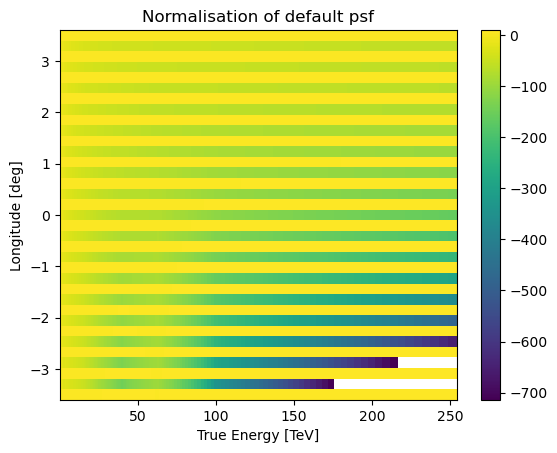

(341, 35)

In [192]:
%time

log10evals, lonvals, latvals, reconlonvals, reconlatvals = np.meshgrid(log10eaxistrue, np.squeeze(longitudeaxistrue),0, np.squeeze(longitudeaxis), 0, indexing='ij')
psfactualvals = np.log(psffull.evaluate(energy_true=10**log10evals.flatten()*u.TeV, offset=lonvals.flatten()*u.deg, rad=np.abs(lonvals.flatten()-reconlonvals.flatten())*u.deg).value).reshape(log10eaxistrue.shape[0],
                                                                                   longitudeaxistrue.shape[0],
                                                                                   longitudeaxis.shape[0])
norms = special.logsumexp(psfactualvals, axis=2)

plt.figure()
plt.title("Normalisation of default psf")
plt.pcolormesh(10**log10eaxistrue, longitudeaxistrue, norms.T)
plt.xlabel('True Energy [TeV]')
plt.ylabel('Longitude [deg]')
plt.colorbar()
plt.show()

norms.shape

In [161]:
psfactualvals.shape

(214830,)

In [162]:
longitudeaxistrue.shape[0]*longitudeaxis.shape[0]

630

In [163]:
psfinterped = interpolate.RegularGridInterpolator((np.squeeze(log10eaxistrue), 
                                                   np.squeeze(longitudeaxistrue), 
                                                   np.squeeze(latitudeaxistrue), 
                                                   np.squeeze(longitudeaxis), 
                                                   np.squeeze(latitudeaxis)), psfmatrix, fill_value=-1000)

In [170]:
%time
log10evals, lonvals, latvals, reconlonvals, reconlatvals = np.meshgrid(log10eaxistrue, np.squeeze(longitudeaxistrue),0, longitudeaxis, 0, indexing='ij')
psfoutput = psfinterped((log10evals.flatten(), 
            lonvals.flatten(), 
            latvals.flatten(), 
            reconlonvals.flatten(), 
            reconlatvals.flatten())).reshape(log10eaxistrue.shape[0],
                                                                                   longitudeaxistrue.shape[0],
                                                                                   longitudeaxis.shape[0])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


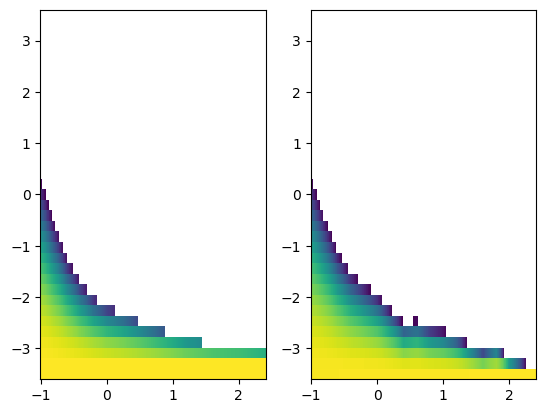

In [171]:
plt.figure()
plt.subplot(1,2,1)
plt.pcolormesh(log10eaxistrue, longitudeaxistrue, psfoutput.T[0,:,:])

plt.subplot(1,2,2)
plt.pcolormesh(log10eaxistrue, longitudeaxistrue, psfactualvals.T[0,:,:])

plt.show()

In [93]:
np.where(np.isnan(reconlatvals))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

## IRF Peek

In [5]:
longitudeaxis_temp, longitudeaxistrue_temp = np.linspace(-3.5, 3.5, 1000), np.linspace(-3.5, 3.5, 10000)
psfnorm_lonrecon_mesh, psfnorm_lontrue_mesh = np.meshgrid(longitudeaxis_temp, longitudeaxistrue_temp)

unnormedpsfvals = psf(np.array([psfnorm_lonrecon_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), np.array([psfnorm_lontrue_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), psfnorm_lonrecon_mesh.flatten()*0).reshape(psfnorm_lonrecon_mesh.shape)

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/970174.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(offsetaxistrue_temp, np.exp(psf(np.array([0,0]), np.array([offsetaxistrue_temp,0]), logetrueval)), label=logetrueval)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/970174.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(offsetval+offsetaxistrue_temp, np.exp(psf(np.array([offsetval,0]), np.array([offsetval+offsetaxistrue_temp,0]), 0)), label=offsetval)


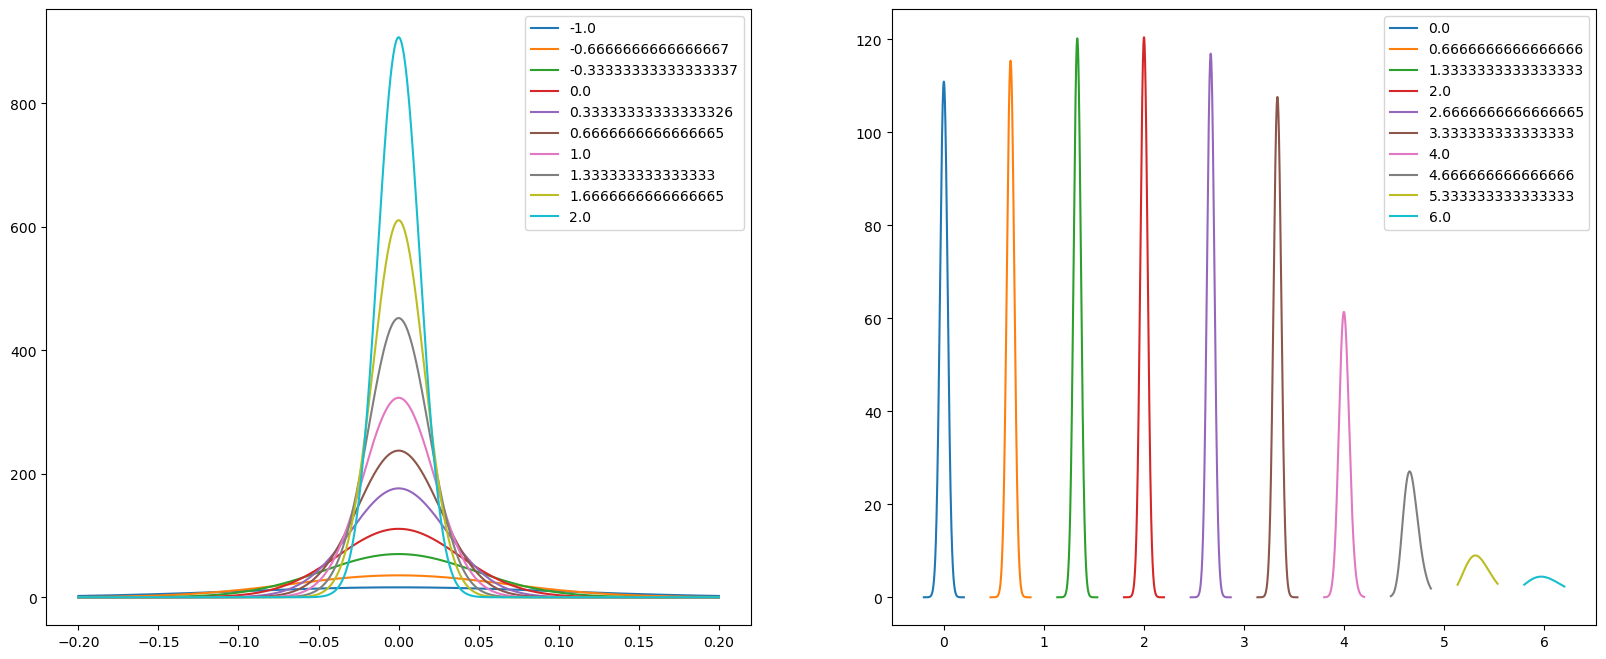

In [6]:
offsetaxis_temp = np.linspace(0, 6, 10)
offsetaxistrue_temp = np.linspace(-0.2, 0.2, 1000)

log10eaxistrue_temp = np.linspace(-1,2,10)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
for logetrueval in log10eaxistrue_temp:
    plt.plot(offsetaxistrue_temp, np.exp(psf(np.array([0,0]), np.array([offsetaxistrue_temp,0]), logetrueval)), label=logetrueval)
plt.legend()

plt.subplot(1,2,2)
for offsetval in offsetaxis_temp:
    plt.plot(offsetval+offsetaxistrue_temp, np.exp(psf(np.array([offsetval,0]), np.array([offsetval+offsetaxistrue_temp,0]), 0)), label=offsetval)
plt.legend()
plt.show()

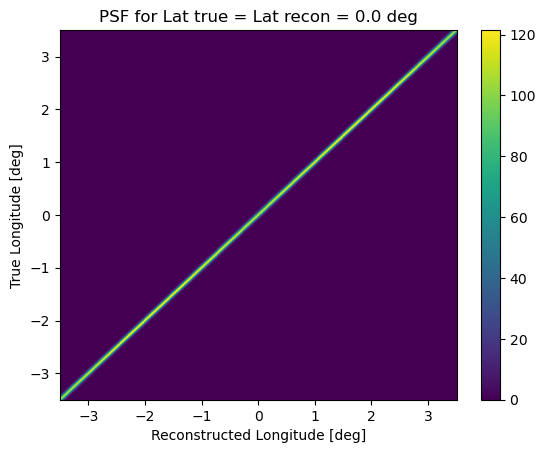

In [7]:
plt.figure()
plt.pcolormesh(longitudeaxis_temp, longitudeaxistrue_temp, np.exp(unnormedpsfvals.T).T)
plt.xlabel("Reconstructed Longitude [deg]")
plt.ylabel("True Longitude [deg]")
plt.title("PSF for Lat true = Lat recon = 0.0 deg")
plt.colorbar()
plt.show()

In [8]:
edispnorm_recon, edispnorm_true = np.meshgrid(log10eaxis,log10eaxistrue)

unnormededispvals = edisp(edispnorm_recon.flatten(),edispnorm_true.flatten(), np.array([edispnorm_recon.flatten()*0+2,edispnorm_recon.flatten()*0+2])).reshape(edispnorm_recon.shape)

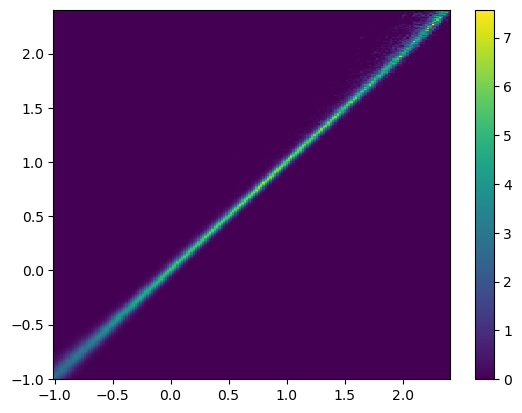

In [9]:
plt.figure()
plt.pcolormesh(log10eaxis, log10eaxistrue, np.exp(unnormededispvals))
plt.colorbar()

# <h1><b>Simulation

## Setup

### Background setup

In [10]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues.T+logjacobtrue)

logbkgpriorvalues.shape

(341, 35, 30)

In [11]:
# Ratio of expected events as compared to 1.08*10^8
simps(y=simps(y=simps(y=np.exp(unnormed_logbkgpriorvalues), x=10**log10eaxistrue, axis=0), x = longitudeaxistrue, axis=0), x=latitudeaxistrue)*60*60*525/1e8

342.9062844419879

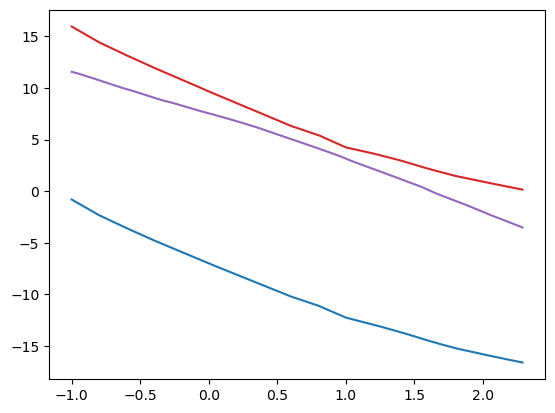

In [12]:
plt.figure()
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues, axis=(1,2)), c='tab:blue')
plt.plot(log10eaxistrue, special.logsumexp(np.log(astrophysicalbackground), axis=(1,2)), c="tab:purple")
plt.plot(log10eaxistrue, special.logsumexp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue), axis=(1,2)), c="tab:red")
plt.show()

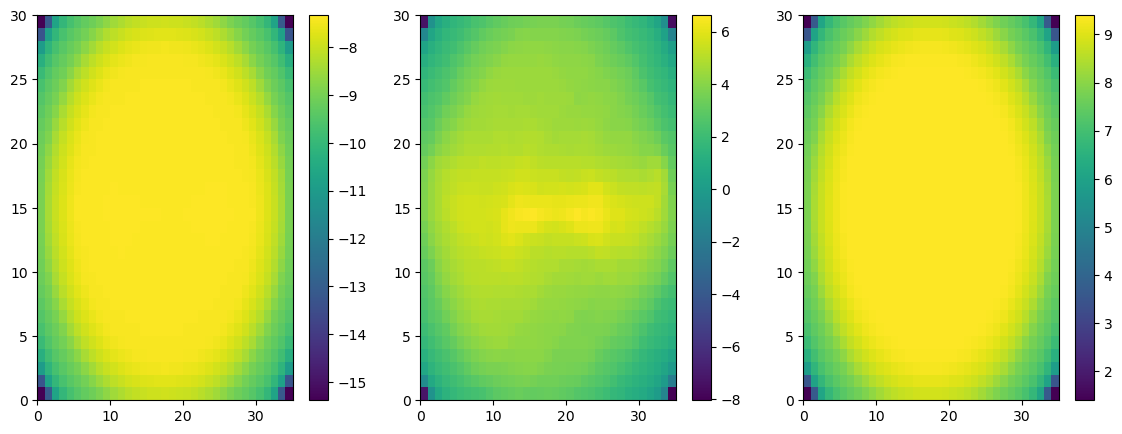

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.pcolormesh(logbkgpriorvalues[0].T)
plt.colorbar()


plt.subplot(1,3,2)
plt.pcolormesh(np.log(astrophysicalbackground)[0].T)
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)[0].T)
plt.colorbar()
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/1991840068.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/1991840068.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


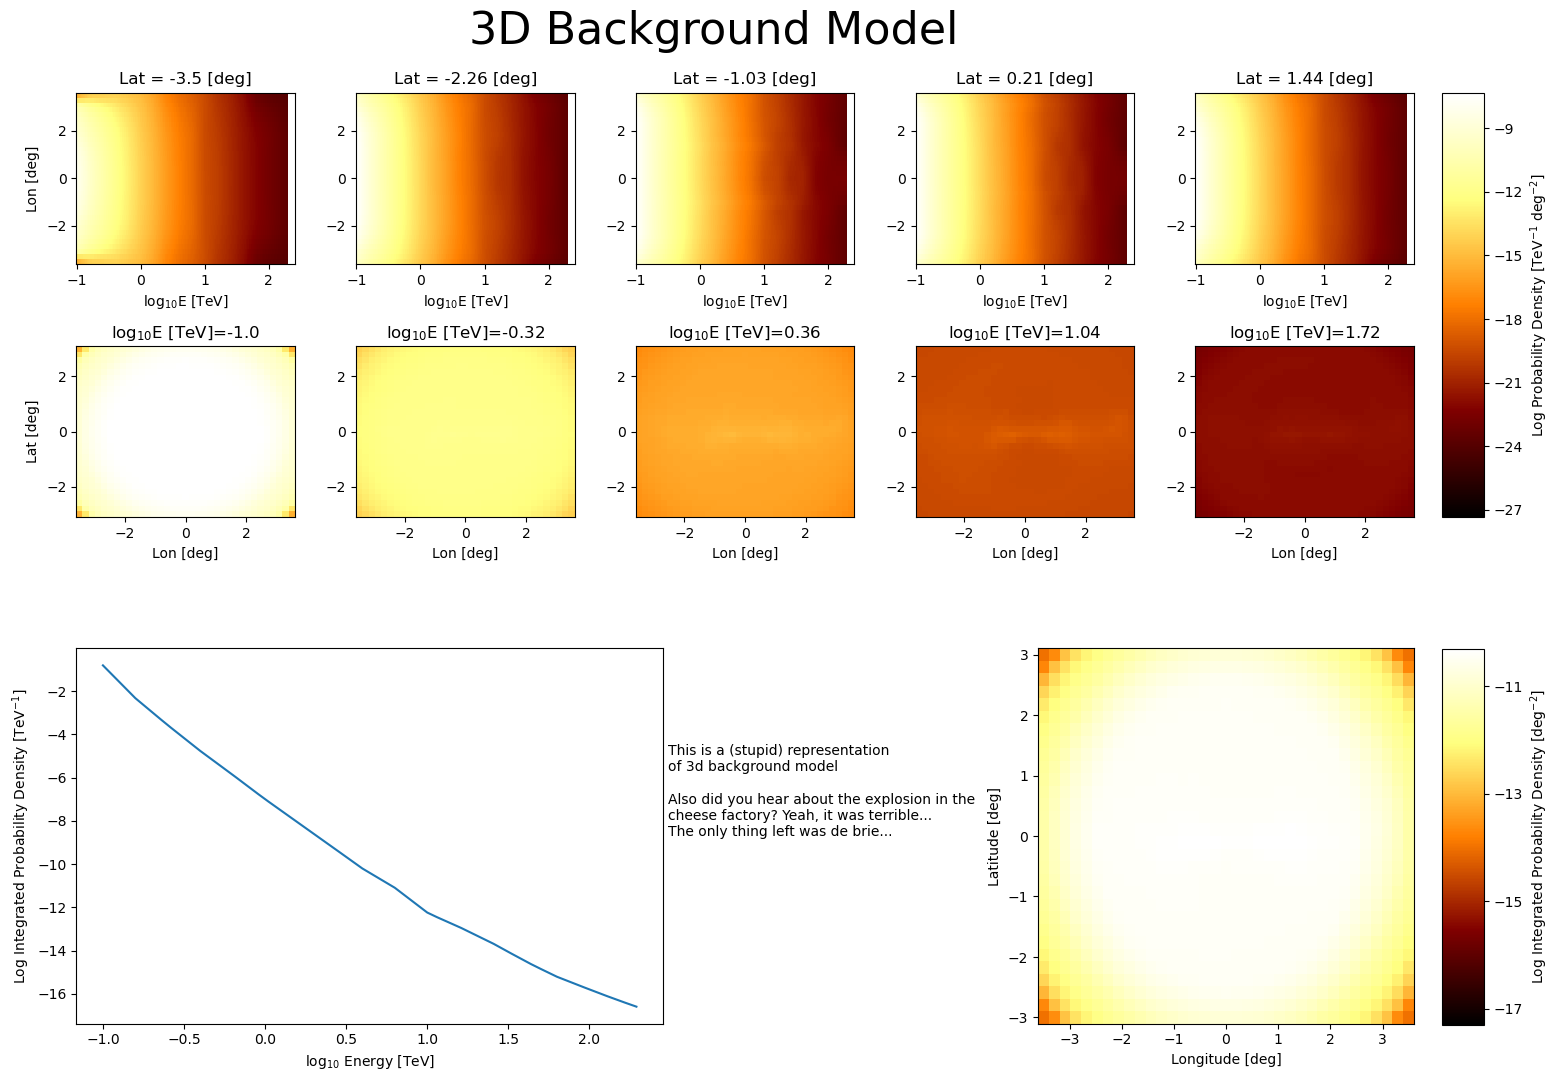

In [14]:
fig,axs = plt.subplots(4,5, figsize=(14,10))


maxval = np.max(logbkgpriorvalues)


spaceconverter = int(np.round(longitudeaxistrue.shape[0]/6))
axs[0,0].pcolormesh(log10eaxistrue, longitudeaxistrue, logbkgpriorvalues[:,:,0].T, 
                    vmin = maxval-20, vmax=maxval, cmap='afmhot')
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, longitudeaxistrue, logbkgpriorvalues[:,:,index*spaceconverter].T, 
                            vmin = maxval-20, vmax=maxval, cmap='afmhot')
    axs[0,index].set_title(f"Lat = {np.round(longitudeaxistrue[index*spaceconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(longitudeaxistrue, latitudeaxistrue, logbkgpriorvalues[0,:,:].T, 
                    vmin = maxval-20, vmax=maxval, cmap='afmhot')
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(longitudeaxistrue, latitudeaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:].T, 
                                   vmin = maxval-20, vmax=maxval, cmap='afmhot')
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues.T+np.log(10**log10eaxistrue*(log10eaxistrue[1]-log10eaxistrue[0])*np.log(10)),axis=2).T
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, integratedvals.T, vmin = integratedmax-7, vmax=integratedmax, cmap='afmhot')
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', 
             ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', 
             ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))


plt.suptitle('3D Background Model', y=1.05, size=32)
# fig.tight_layout(pad=5.0)
plt.show()

### Signal Setup

In [15]:
signalspecfunc = energymassinputspectralfunc
signalfunc = setup_full_fake_signal_dist(truelogmassval, signalspecfunc)
truelogmassval

1.0

In [16]:
log10emeshtrue.shape

(341, 35, 30)

In [17]:
logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

print(logsigpriorvalues.shape)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues.T+logjacobtrue))
logsigpriorvalues.shape

(341, 35, 30)


(341, 35, 30)

In [18]:
np.mean(jfact)

5.059621014601303e+23

In [19]:
lonmeshtrue[:,0,0]

array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/236058929.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/236058929.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,14,22)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/236058929.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


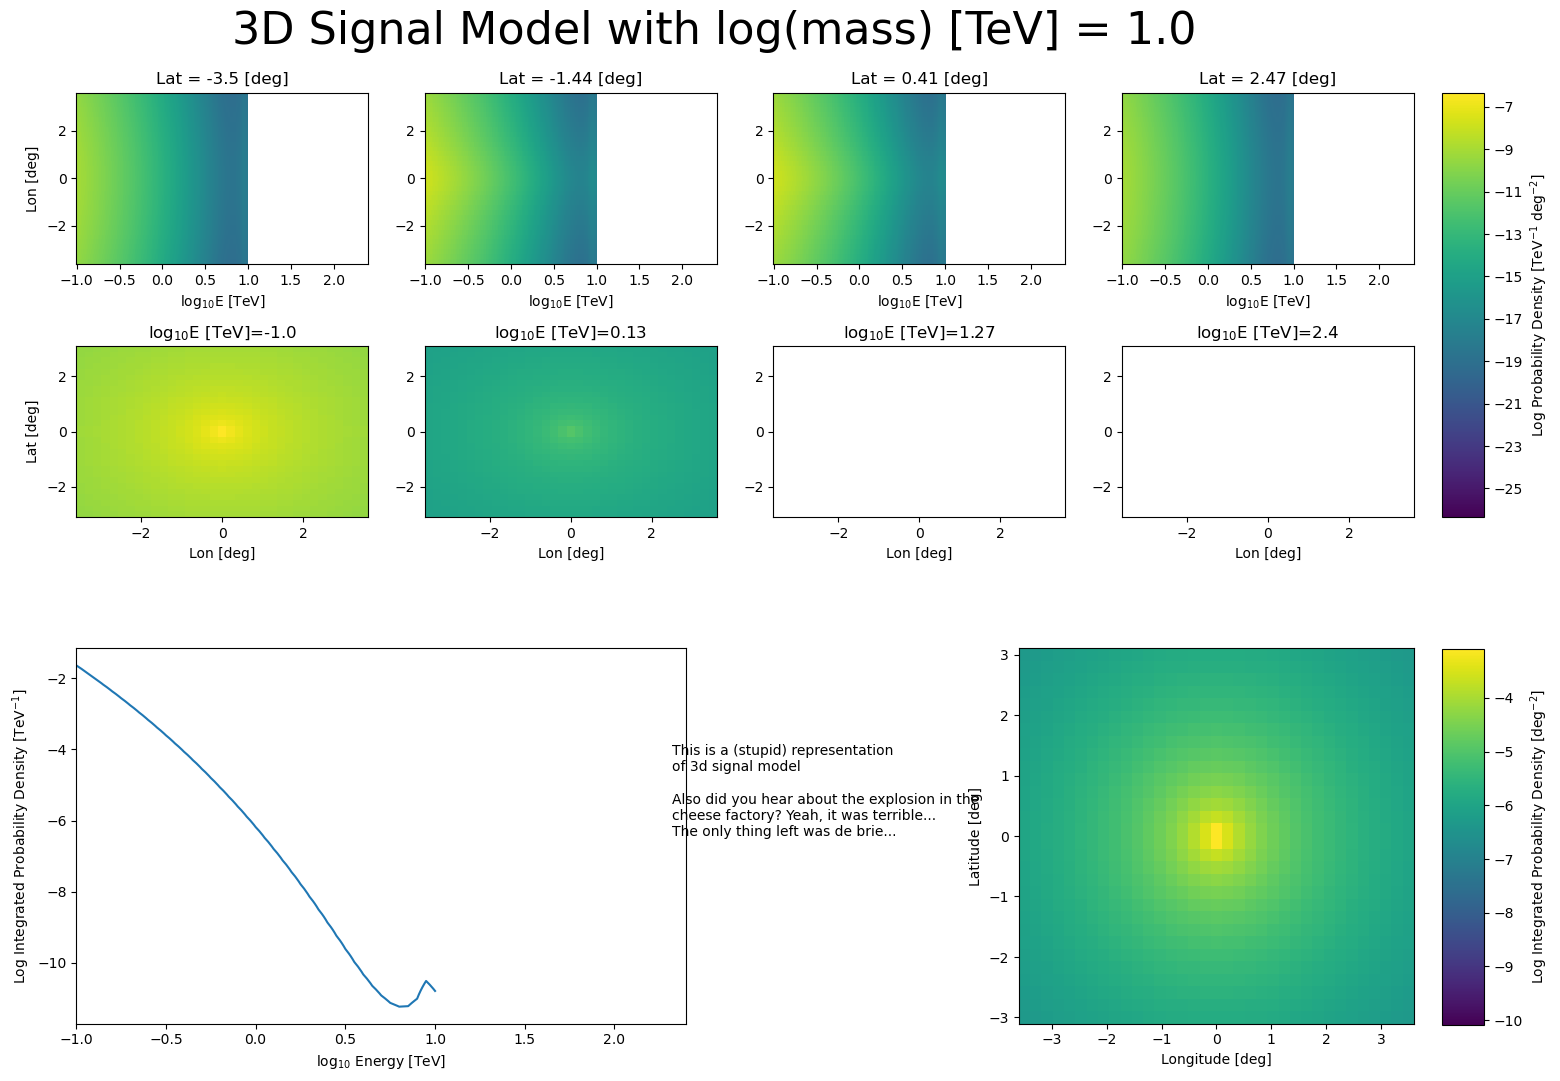

In [20]:
numslices = 4
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

spaceconverter = np.round(np.linspace(0, latitudeaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, longitudeaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, longitudeaxistrue, logsigpriorvalues[:,:,int(spaceconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(longitudeaxistrue[int(spaceconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(longitudeaxistrue, latitudeaxistrue, logsigpriorvalues[0,:,:].T, vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(longitudeaxistrue, latitudeaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:].T, vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,14,22)
plt.axis('off')
plt.text(x=-1,y=0.5,s="""This is a (stupid) representation 
of 3d signal model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, integratedvals.T, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
plt.suptitle(f'3D Signal Model with log(mass) [TeV] = {truelogmassval}', y=1.05, size=32)

# fig.tight_layout(pad=5.0)
plt.show()

## True Value Simulation

In [21]:
logsigbinnedprior = (logsigpriorvalues.T+logjacobtrue).T
flattened_logsigbinnedprior = logsigbinnedprior.flatten()


logbkgbinnedprior = (logbkgpriorvalues.T+logjacobtrue).T
flattened_logbkgbinnedprior = logbkgbinnedprior.flatten()

In [22]:

if truelambda!=0.0:
    sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_logsigbinnedprior, Nsamples=nsig),logsigbinnedprior.shape)
    siglogevals = log10eaxistrue[sigresultindices[0]]
    siglonvals = longitudeaxistrue[sigresultindices[1]]
    siglatvals = latitudeaxistrue[sigresultindices[2]]
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2636887125.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2636887125.py:29: RuntimeWarning: invalid value encountered in true_divide
  ratios = signalplotvalues_intermediate[1:]/sigspechistvals[0]
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2636887125.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2636887125.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


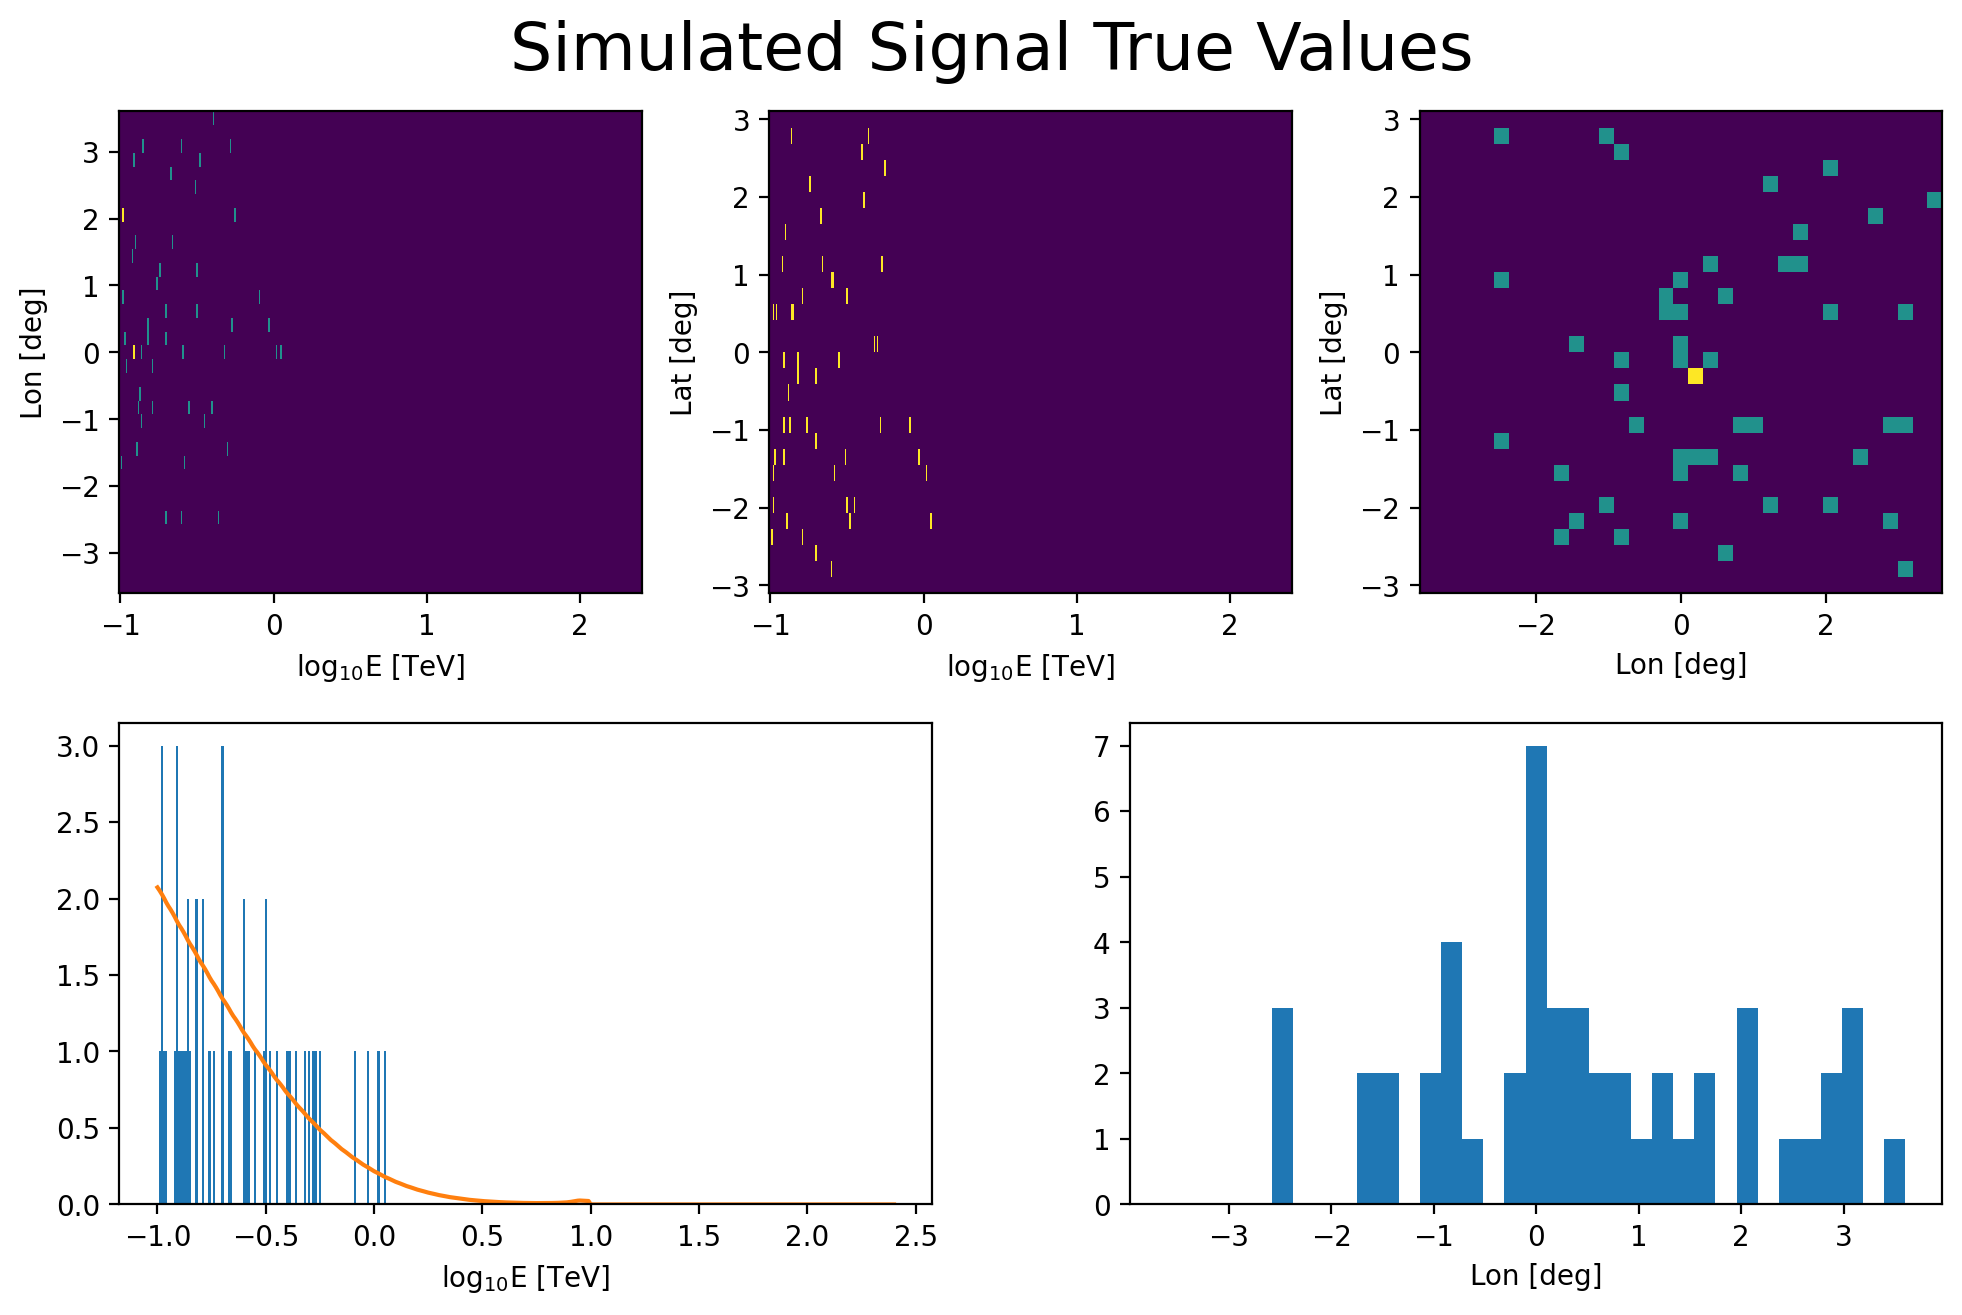

In [23]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(siglogevals, siglonvals, bins=[plotlog10eaxistrue,plotlongitudeaxistrue])
plt.ylabel('Lon [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,3,2)
plt.hist2d(siglogevals, siglatvals, bins=[plotlog10eaxistrue,plotlatitudeaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lat [deg]')



plt.subplot(2,3,3)
plt.hist2d(siglonvals, siglatvals, bins=[plotlongitudeaxistrue,plotlatitudeaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

sigspecvals = np.squeeze(np.exp(makelogjacob(plotlog10eaxistrue)+np.squeeze(signalspecfunc(truelogmassval, plotlog10eaxistrue))))
plt.subplot(2,2,3)
sigspechistvals = plt.hist(siglogevals, bins=plotlog10eaxistrue)
signalplotvalues_intermediate = sigspecvals/np.max(sigspecvals)*np.max(sigspechistvals[0])

ratios = signalplotvalues_intermediate[1:]/sigspechistvals[0]
ratios = ratios[~np.isinf(ratios)]
averagediffratio = np.nanmean(ratios)
plt.plot(log10eaxistrue, signalplotvalues_intermediate[1:]/averagediffratio)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(siglonvals, bins=plotlongitudeaxistrue)
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

plt.suptitle("Simulated Signal True Values", y=1.05, size=24)
plt.show()

In [24]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_logbkgbinnedprior, Nsamples=nbkg),logbkgbinnedprior.shape)
bkglogevals = log10eaxistrue[bkgresultindices[0]]
bkglonvals = longitudeaxistrue[bkgresultindices[1]]
bkglatvals = latitudeaxistrue[bkgresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/3501848987.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/3501848987.py:29: RuntimeWarning: invalid value encountered in true_divide
  bkgaveragediffratio = np.nanmean(bkgspechistvals[0]/backgroundplotvalues_intermediate[1:])
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/3501848987.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/3501848987.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_lay

0.28142941162131224


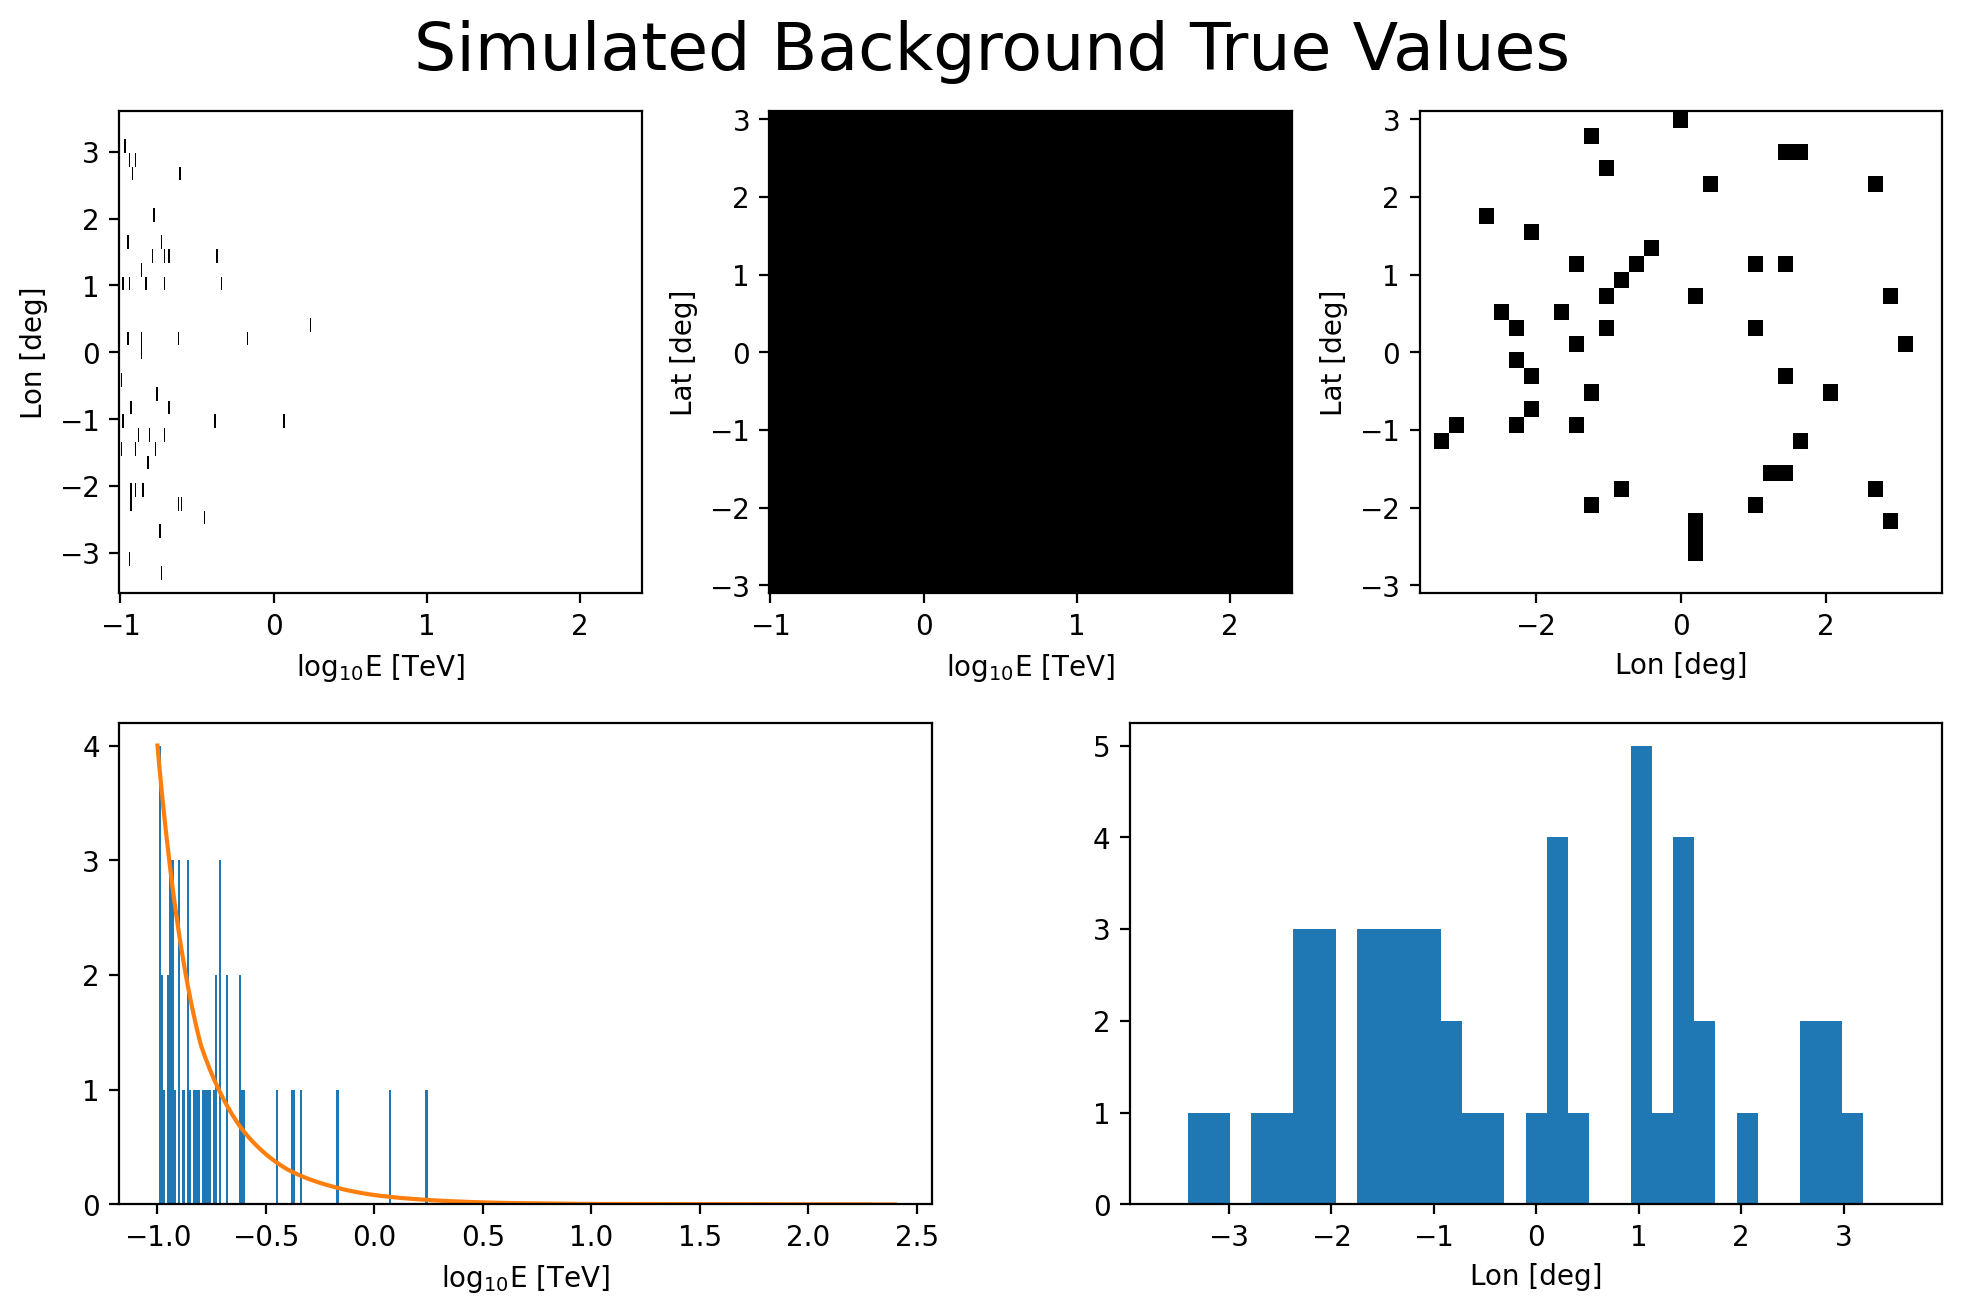

In [25]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkglogevals, bkglonvals, bins=[plotlog10eaxistrue,plotlongitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkglogevals, bkglatvals, bins=[plotlog10eaxistrue,plotlatitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkglonvals, bkglatvals, bins=[plotlongitudeaxistrue,plotlatitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)


logbkgspecvals = special.logsumexp(makelogjacob(plotlog10eaxistrue[:-1])+logbkgpriorvalues.T, axis=(0,1))
bkgspecvals = np.squeeze(np.exp(logbkgspecvals-special.logsumexp(logbkgspecvals)))

plt.subplot(2,2,3)
bkgspechistvals =plt.hist(bkglogevals, bins=plotlog10eaxistrue[:-1])
backgroundplotvalues_intermediate = bkgspecvals/np.max(bkgspecvals)*np.max(bkgspechistvals[0])
bkgaveragediffratio = np.nanmean(bkgspechistvals[0]/backgroundplotvalues_intermediate[1:])
print(bkgaveragediffratio)
plt.plot(log10eaxistrue, backgroundplotvalues_intermediate)#*bkgaveragediffratio)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkglonvals, bins=plotlongitudeaxistrue)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background True Values", y=1.05, size=24)

plt.show()

## Reconstructed Value Simulation

In [26]:
lonmeshrecon.shape

(18, 15)

In [27]:
for coord in np.array([siglonvals, siglatvals]).T:
    print(coord)

[ 2.88235294 -2.17241379]
[-1.64705882 -1.55172414]
[ 2.88235294 -0.93103448]
[ 0.82352941 -1.55172414]
[ 0.20588235 -0.31034483]
[3.08823529 0.51724138]
[-2.47058824 -1.13793103]
[ 2.05882353 -1.96551724]
[1.64705882 1.13793103]
[-2.47058824  2.79310345]
[1.64705882 1.55172414]
[ 0.20588235 -1.34482759]
[-0.82352941 -0.10344828]
[0.         0.10344828]
[ 0.82352941 -0.93103448]
[ 0.61764706 -2.5862069 ]
[ 0.         -2.17241379]
[ 0.         -0.10344828]
[0.41176471 1.13793103]
[-1.64705882 -2.37931034]
[-0.82352941 -2.37931034]
[ 3.08823529 -2.79310345]
[ 3.08823529 -0.93103448]
[-0.20588235  0.72413793]
[ 1.02941176 -0.93103448]
[3.5        1.96551724]
[-2.47058824  0.93103448]
[1.44117647 1.13793103]
[ 1.23529412 -1.96551724]
[-0.61764706 -0.93103448]
[2.67647059 1.75862069]
[0.         0.93103448]
[0.         0.51724138]
[ 0.         -1.34482759]
[ 0.20588235 -0.31034483]
[0.61764706 0.72413793]
[2.05882353 0.51724138]
[-1.44117647  0.10344828]
[-0.82352941  2.5862069 ]
[ 0.411764

### Signal

In [28]:

if truelambda!=0.0:
    signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])]
else:
    signal_log10e_measured = np.asarray([])

100%|██████████| 50/50 [00:00<00:00, 1063.31it/s]


In [29]:

if truelambda!=0:
    signal_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])
    signal_reshaped_indices = np.unravel_index(signal_spatial_indices, shape=lonmeshrecon.shape)
    signal_lon_measured = longitudeaxis[signal_reshaped_indices[0]]
    signal_lat_measured = latitudeaxis[signal_reshaped_indices[1]]
else:
    signal_lon_measured = np.asarray([])
    signal_lat_measured = np.asarray([])


100%|██████████| 50/50 [00:00<00:00, 141.08it/s]


In [30]:
# np.max(signal_reshaped_indices[1])

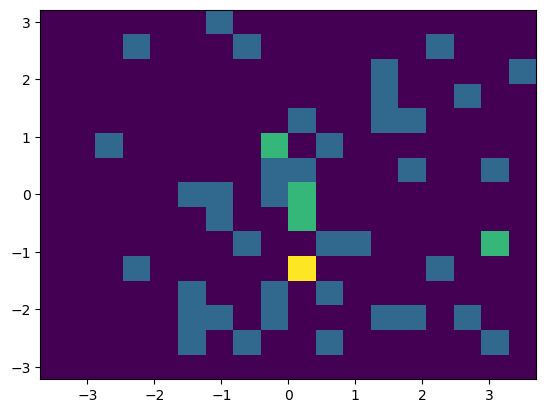

In [31]:
plt.figure()
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=[plotlongitudeaxis, plotlatitudeaxis])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2887056561.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2887056561.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/2887056561.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


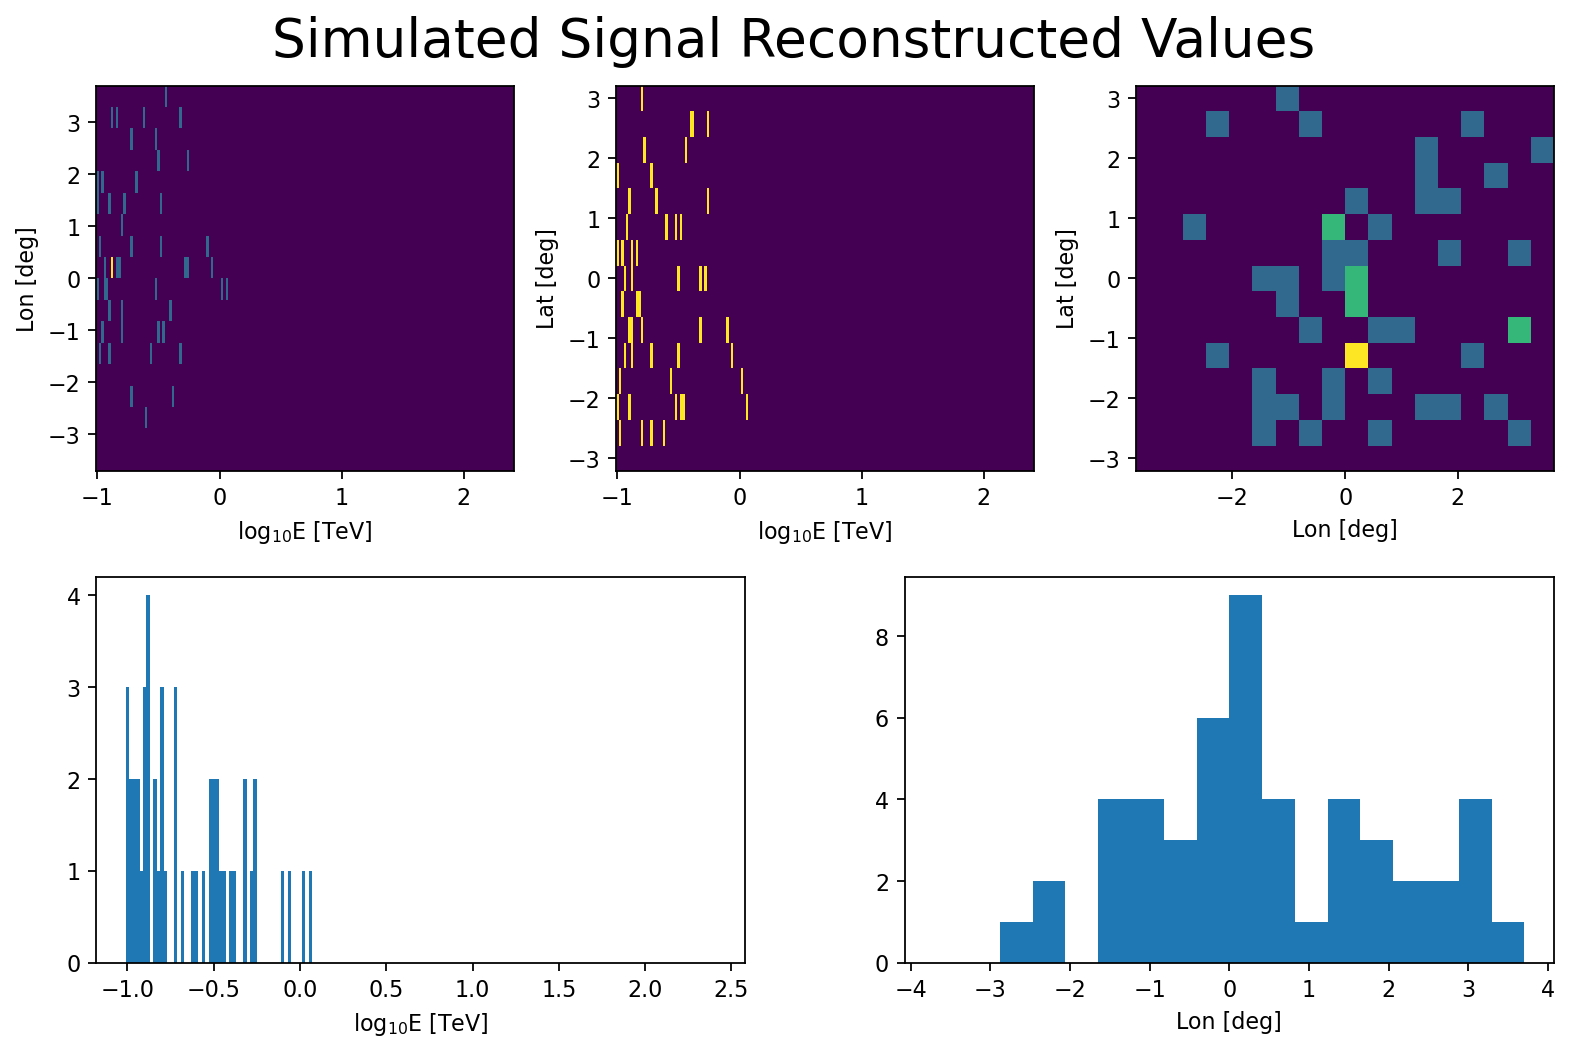

In [32]:
plt.subplots(2,3,dpi=160,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(signal_log10e_measured, signal_lon_measured, bins=[plotlog10eaxis,plotlongitudeaxis])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(signal_log10e_measured, signal_lat_measured, bins=[plotlog10eaxis,plotlatitudeaxis])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=[plotlongitudeaxis, plotlatitudeaxis])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(signal_log10e_measured, bins=plotlog10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(signal_lon_measured, bins=plotlongitudeaxis)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Signal Reconstructed Values", y=1.05, size=24)

plt.show()

### Background

In [33]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])]

100%|██████████| 50/50 [00:00<00:00, 1437.31it/s]


In [34]:
bkg_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])
bkg_reshaped_indices = np.unravel_index(bkg_spatial_indices, shape=lonmeshrecon.shape)
bkg_lon_measured = longitudeaxis[bkg_reshaped_indices[0]]
bkg_lat_measured = latitudeaxis[bkg_reshaped_indices[1]]


100%|██████████| 50/50 [00:00<00:00, 143.74it/s]


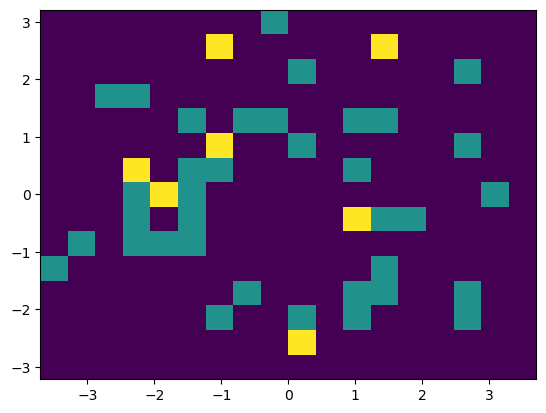

In [35]:
try:
    plt.figure()
    plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[plotlongitudeaxis,plotlatitudeaxis])
    plt.show()
except:
    pass

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/4251250309.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/4251250309.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/4251250309.py:36: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


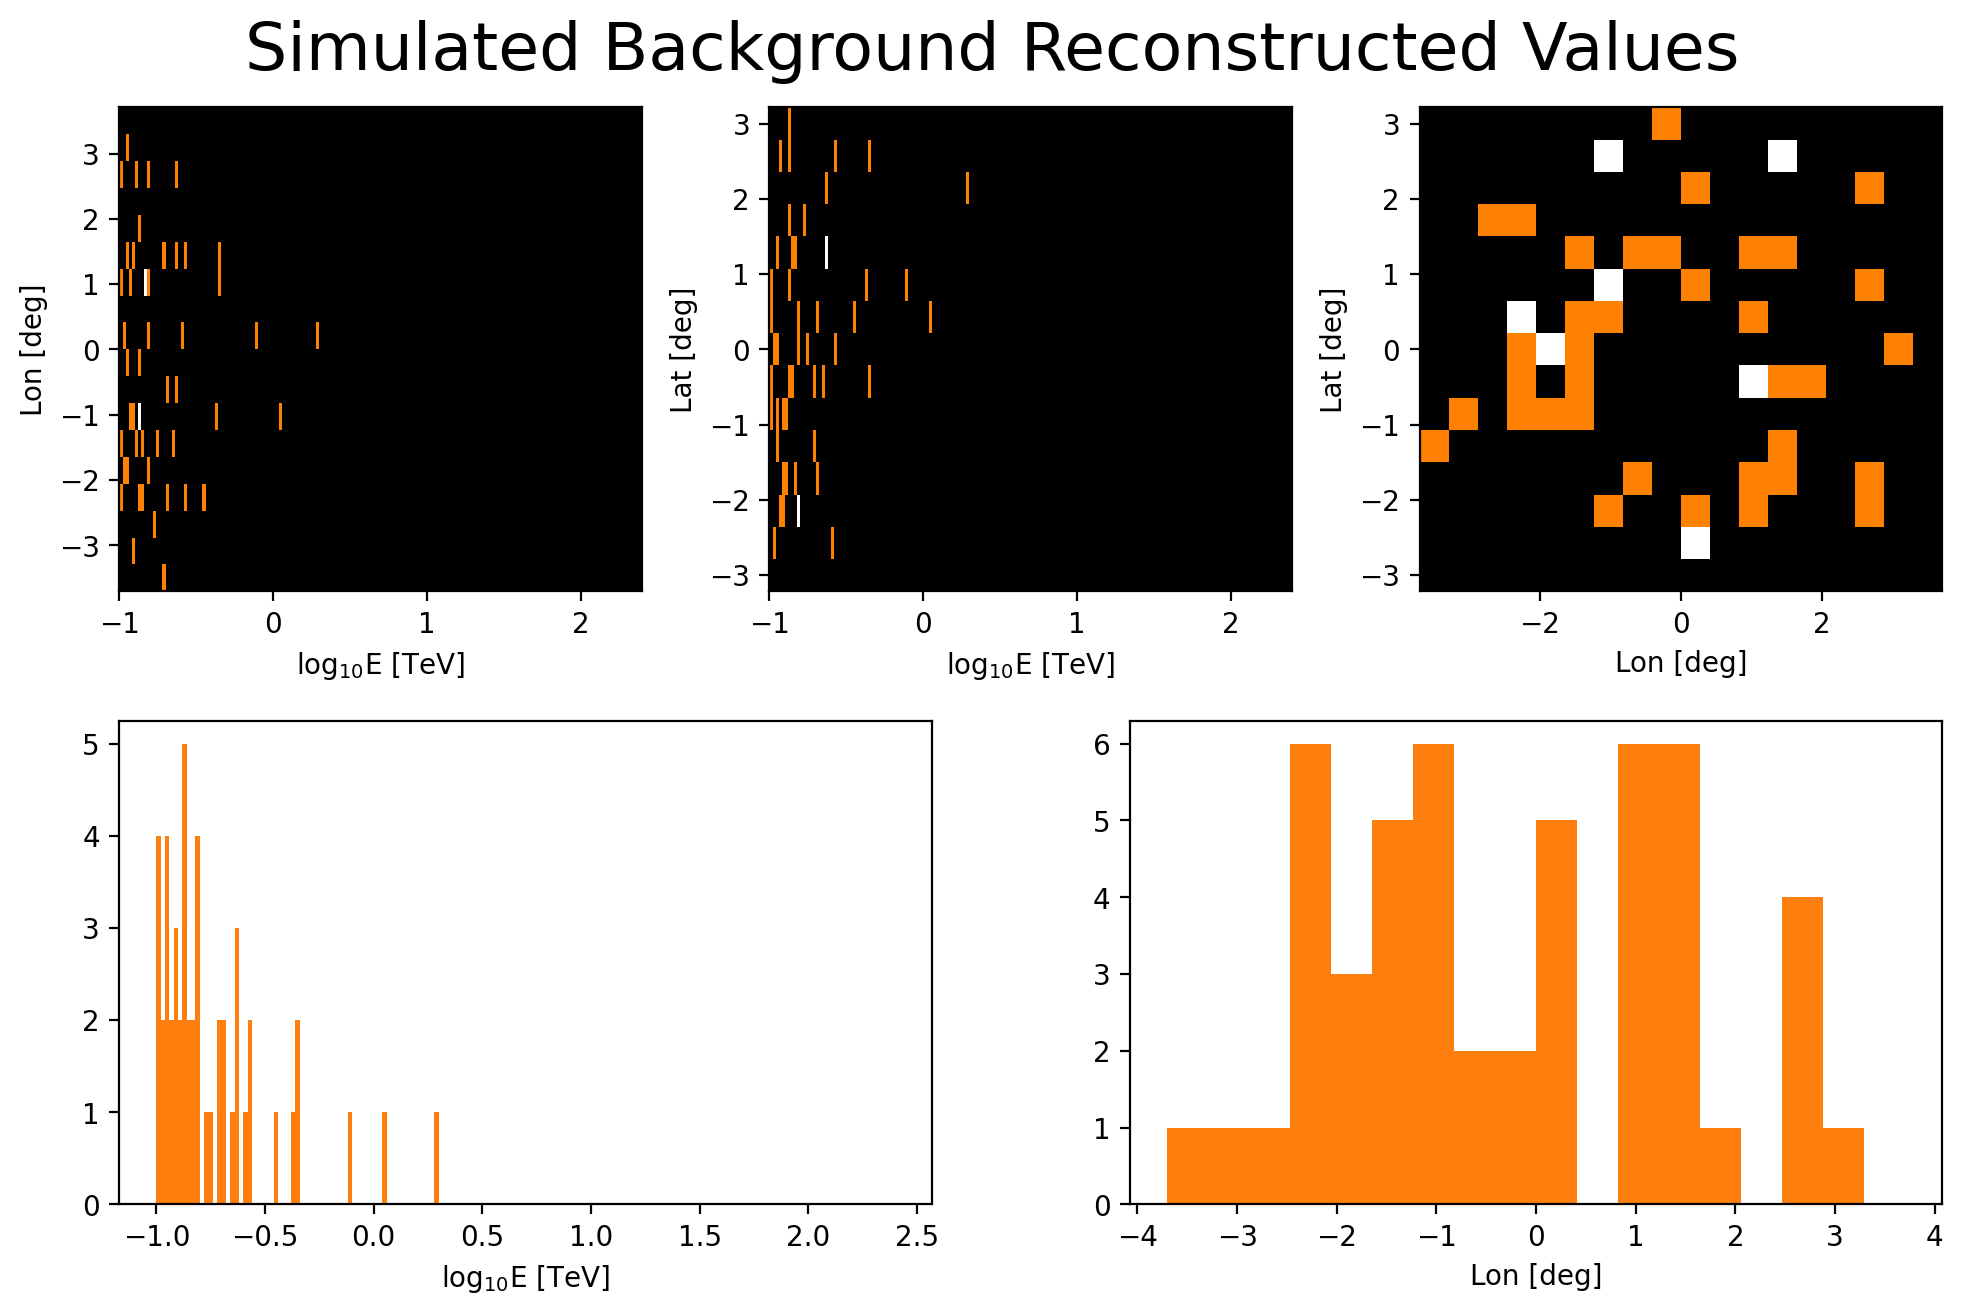

In [36]:

try:
    plt.subplots(2,3,dpi=200,figsize=(10,6))

    plt.subplot(2,3,1)
    plt.hist2d(bkg_log10e_measured, bkg_lon_measured, bins=[log10eaxis,plotlongitudeaxis], cmap='afmhot')
    plt.xlabel(r'log$_{10}$E [TeV]')
    plt.ylabel('Lon [deg]')


    plt.subplot(2,3,2)
    plt.hist2d(bkg_log10e_measured, bkg_lat_measured, bins=[log10eaxis,plotlatitudeaxis], cmap='afmhot')
    plt.ylabel('Lat [deg]')
    plt.xlabel(r'log$_{10}$E [TeV]')


    plt.subplot(2,3,3)
    plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[plotlongitudeaxis,plotlatitudeaxis], cmap='afmhot')
    plt.ylabel('Lat [deg]')
    plt.xlabel('Lon [deg]')

    plt.tight_layout(pad=1.0)



    plt.subplot(2,2,3)
    plt.hist(bkg_log10e_measured, bins=log10eaxis, color='tab:orange')
    plt.xlabel(r'log$_{10}$E [TeV]')



    plt.subplot(2,2,4)
    plt.hist(bkg_lon_measured, bins=plotlongitudeaxis, color='tab:orange')
    plt.xlabel('Lon [deg]')


    plt.tight_layout(pad=1.0)


    plt.suptitle("Simulated Background Reconstructed Values", y=1.05, size=24)

    plt.show()
except:
    pass

## Final simulation output

In [37]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

In [38]:
type(bkg_log10e_measured)

numpy.ndarray

# <h1><b>Analysis

## IRF Normalisation

In [39]:
# Save the matrix of psf values in its entirety (not just normalisation values)?
lontrue_mesh_psf, logetrue_mesh_psf, lattrue_mesh_psf, lonrecon_mesh_psf, latrecon_mesh_psf = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue, longitudeaxis, latitudeaxis)
# psfmatrix = psf(np.array([lonrecon_mesh_psf.flatten(), latrecon_mesh_psf.flatten()]), np.array([lontrue_mesh_psf.flatten(), lattrue_mesh_psf.flatten()]), logetrue_mesh_psf.flatten()).reshape(logetrue_mesh_psf.shape)
psfmatrix = np.load("psfmatrix.npy")


    
lontrue_mesh_edisp, logetrue_mesh_edisp, lattrue_mesh_edisp, logerecon_mesh_edisp,  = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue, log10eaxis)


# edispmatrix = edisp(logerecon_mesh_edisp.flatten(), logetrue_mesh_edisp.flatten(), np.array([lontrue_mesh_edisp.flatten(), lattrue_mesh_edisp.flatten()])).reshape(logetrue_mesh_edisp.shape)
edispmatrix = np.load("edispmatrix.npy")



psfnormalisation  = special.logsumexp(psfmatrix, axis=(-2,-1))

edispnormalisation  = special.logsumexp(edispmatrix+logjacob, axis=-1)


edispnormalisation[edispnormalisation==-np.inf] = 0
psfnormalisation[psfnormalisation==-np.inf] = 0   

edispmatrix = edispmatrix-edispnormalisation[:,:,:,np.newaxis]
psfmatrix = psfmatrix-psfnormalisation[:,:,:,np.newaxis, np.newaxis]


psfnormalisation  = special.logsumexp(psfmatrix, axis=(-2,-1))

edispnormalisation  = special.logsumexp(edispmatrix+logjacob, axis=-1)


edispnormalisation[edispnormalisation==-np.inf] = 0
psfnormalisation[psfnormalisation==-np.inf] = 0   

edispmatrix = edispmatrix-edispnormalisation[:,:,:,np.newaxis]
psfmatrix = psfmatrix-psfnormalisation[:,:,:,np.newaxis, np.newaxis]

np.save("psfmatrix.npy", psfmatrix)
np.save("edispmatrix.npy", edispmatrix)



In [40]:
psfmatrix.shape

(341, 35, 30, 18, 15)

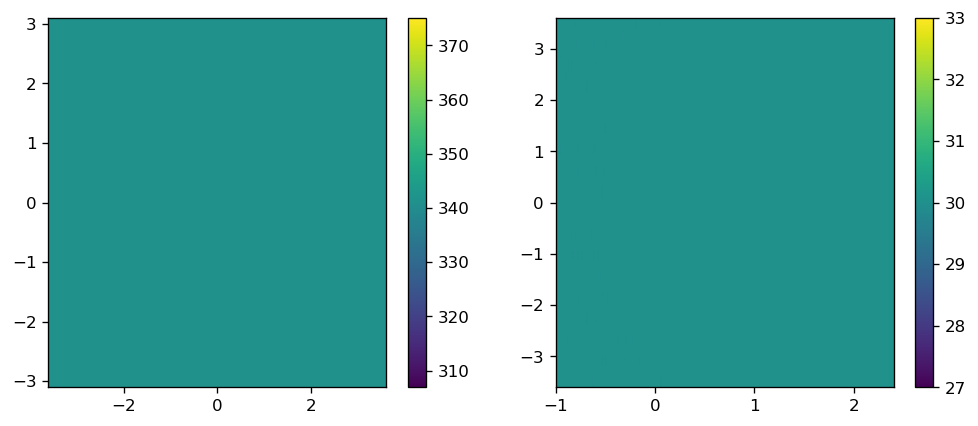

In [41]:
plt.subplots(1,2, figsize=(10,4), dpi=120)
plt.subplot(1,2,1)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(psfnormalisation, axis=0)).T)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(log10eaxistrue, longitudeaxistrue, np.exp(special.logsumexp(psfnormalisation, axis=2)).T)
plt.colorbar()


In [42]:
np.std(edispnormalisation.T)

1.4465290598977117e-16

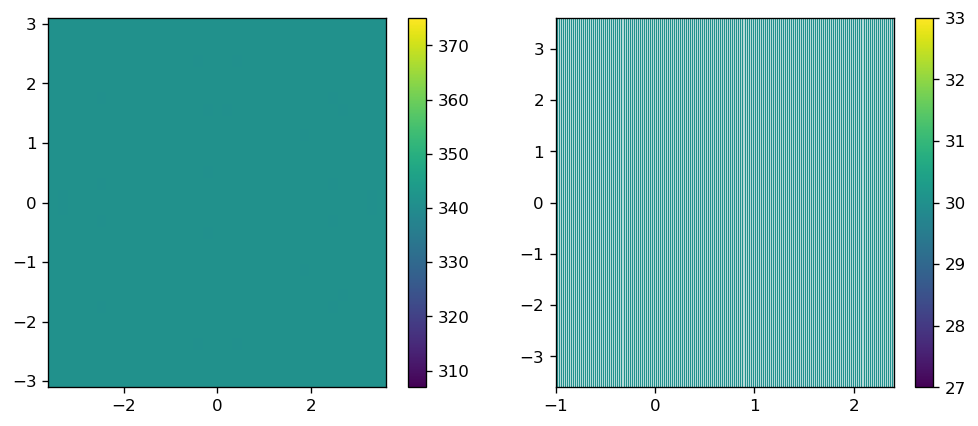

In [43]:
plt.subplots(1,2, figsize=(10,4), dpi=120)
plt.subplot(1,2,1)
pcol1 = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(edispnormalisation.T, axis=2)))
plt.colorbar(pcol1)


plt.subplot(1,2,2)
pcol2 = plt.pcolormesh(log10eaxistrue, longitudeaxistrue, np.exp(special.logsumexp(edispnormalisation.T, axis=0)))

for val in log10eaxis:
    plt.axvline(val, alpha=1, color='white', lw=0.4)
plt.colorbar(pcol2)


## IRF Indices

In [44]:
# lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

# irfproblist = []

# for logeval, coord in notebook_tqdm(zip(measured_log10e, np.array([measured_lon, measured_lat]).T), total=len(list(measured_log10e))):
#     irfproblist.append(psf(coord, np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()]), logetrue_mesh_nuisance.flatten()).reshape(logetrue_mesh_nuisance.shape)+\
#         edisp(logeval, logetrue_mesh_nuisance.flatten(), np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()])).reshape(logetrue_mesh_nuisance.shape) - edispnormalisation - psfnormalisation)

In [45]:
# lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

# irfproblist = []

# calcdemderirfvals_temp = functools.partial(calcdemderirfvals, lontrue_mesh_nuisance=lontrue_mesh_nuisance, logetrue_mesh_nuisance=logetrue_mesh_nuisance, lattrue_mesh_nuisance=lattrue_mesh_nuisance, 
#                                            edispnormalisation=edispnormalisation,  psfnormalisation=psfnormalisation)
    
# with Pool(numcores) as pool: 
        
#     for result in notebook_tqdm(pool.imap(calcdemderirfvals_temp, zip(measured_log10e, np.array([measured_lon, measured_lat]).T)), total=len(list(measured_log10e)), ncols=100, desc="Calculating irf values..."):
#             irfproblist.append(result)

#     pool.close() 

In [46]:
lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue)

irfindexlist = []

    
with Pool(numcores) as pool: 
    
        
    for result in notebook_tqdm(pool.imap(calcrirfindices, zip(measured_log10e, np.array([measured_lon, measured_lat]).T)), total=len(list(measured_log10e)), ncols=100, desc="Calculating irf values..."):
            irfindexlist.append(result)

    pool.close() 
    
irfindexlist = np.array(irfindexlist)

Calculating irf values...:   0%|                                            | 0/100 [00:00<?, ?it/s]

Calculating irf values...: 100%|██████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


In [47]:
irfindexlist

array([[24, 15,  2],
       [22,  5,  3],
       [ 6, 16,  5],
       [ 1, 10,  3],
       [ 9,  9,  6],
       [ 8, 16,  8],
       [14,  3,  4],
       [ 0, 13,  2],
       [16, 13, 10],
       [31,  3, 13],
       [ 0, 12, 11],
       [ 3,  9,  4],
       [25,  6,  7],
       [36,  9,  7],
       [45, 10,  5],
       [14, 10,  1],
       [53,  8,  2],
       [ 3,  8,  7],
       [37,  9, 10],
       [ 1,  5,  1],
       [10,  7,  1],
       [19, 16,  1],
       [34, 16,  5],
       [ 4,  8,  9],
       [10, 11,  5],
       [28, 17, 12],
       [20,  2,  9],
       [ 5, 12, 10],
       [26, 12,  2],
       [ 5,  7,  5],
       [14, 15, 11],
       [24,  8,  9],
       [ 6,  9,  8],
       [ 6,  9,  4],
       [ 8,  9,  6],
       [26, 10,  9],
       [ 2, 13,  8],
       [34,  5,  7],
       [30,  7, 13],
       [47,  9,  4],
       [25, 14,  4],
       [27,  6,  2],
       [51,  8,  3],
       [ 6,  9,  7],
       [ 2,  6,  6],
       [ 5,  5,  2],
       [11, 12, 12],
       [10,  

In [48]:
irfindexlist[:,0]

array([24, 22,  6,  1,  9,  8, 14,  0, 16, 31,  0,  3, 25, 36, 45, 14, 53,
        3, 37,  1, 10, 19, 34,  4, 10, 28, 20,  5, 26,  5, 14, 24,  6,  6,
        8, 26,  2, 34, 30, 47, 25, 27, 51,  6,  2,  5, 11, 10, 37,  0, 18,
        7,  6, 27, 18,  1,  4,  6,  9,  4,  3,  6,  9,  0, 52,  0,  6,  0,
       32, 31,  6, 11,  2, 15, 14,  9,  2, 21,  3,  5, 12,  0,  2,  8,  5,
        8, 15, 32, 64, 17, 44,  9, 21,  1, 20,  2,  4,  7, 18, 14])

In [49]:
assert len(irfindexlist) == Nsamples
assert irfindexlist.ndim==2
assert irfindexlist.shape==(Nsamples, 3)

In [50]:
print(edispnormalisation.shape,edispmatrix[:,:,:,1].shape)
print(psfnormalisation.shape,psfmatrix[:,:,:,1,2].shape)

(341, 35, 30) (341, 35, 30)
(341, 35, 30) (341, 35, 30)


In [51]:
vals = [print(irfcoord,'\n') for irfcoord in irfindexlist]

[24 15  2] 

[22  5  3] 

[ 6 16  5] 

[ 1 10  3] 

[9 9 6] 

[ 8 16  8] 

[14  3  4] 

[ 0 13  2] 

[16 13 10] 

[31  3 13] 

[ 0 12 11] 

[3 9 4] 

[25  6  7] 

[36  9  7] 

[45 10  5] 

[14 10  1] 

[53  8  2] 

[3 8 7] 

[37  9 10] 

[1 5 1] 

[10  7  1] 

[19 16  1] 

[34 16  5] 

[4 8 9] 

[10 11  5] 

[28 17 12] 

[20  2  9] 

[ 5 12 10] 

[26 12  2] 

[5 7 5] 

[14 15 11] 

[24  8  9] 

[6 9 8] 

[6 9 4] 

[8 9 6] 

[26 10  9] 

[ 2 13  8] 

[34  5  7] 

[30  7 13] 

[47  9  4] 

[25 14  4] 

[27  6  2] 

[51  8  3] 

[6 9 7] 

[2 6 6] 

[5 5 2] 

[11 12 12] 

[10  6 14] 

[37 14 13] 

[0 8 8] 

[18 12 10] 

[ 7  5 10] 

[ 6  8 14] 

[27  3  8] 

[18  7 10] 

[1 4 7] 

[ 4 12  3] 

[ 6 13  6] 

[9 4 7] 

[4 1 5] 

[ 3  6 13] 

[ 6  6 13] 

[ 9 15  2] 

[ 0 15  9] 

[52  6  8] 

[0 3 5] 

[6 6 9] 

[0 5 8] 

[32 11  6] 

[31  6  9] 

[ 6  3 11] 

[11  2 11] 

[ 2 12  4] 

[15  7  3] 

[14 12  6] 

[9 9 2] 

[2 4 5] 

[21 12 13] 

[ 3 11  2] 

[5 5 5] 

[12  5  7] 

[ 0 11  6] 



## Background Marginalisation

In [52]:
bkgpriorarray  = logbkgpriorvalues
# bkgpriorarray = bkgpriorarray.T - special.logsumexp(bkgpriorarray.T+logjacobtrue)

tempbkgmargfunc = functools.partial(marginalisenuisance, prior=bkgpriorarray, edispmatrix=edispmatrix, psfmatrix=psfmatrix)
bkgmargvals = [tempbkgmargfunc(singleeventindices) for singleeventindices in tqdm(irfindexlist, total=irfindexlist.shape[0])]


bkgmargvals = np.array(bkgmargvals)
print(bkgmargvals.shape)

100%|██████████| 100/100 [00:00<00:00, 113.78it/s]

(100,)


## Signal marginalisation

In [53]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')





nbinslogmass            = 61
logmasswindowwidth      = 7/np.sqrt(nsig)


logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth



if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 







nbinslambda            = 101
lambdawindowwidth      = 8/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 


In [54]:
if __name__=="__main__":
    print(time.strftime("Current time is %d of %b, at %H:%M:%S"))

    sigmarg_partial = functools.partial(sigmarg, specfunc=signalspecfunc, irfindexlist=irfindexlist, edispmatrix=edispmatrix, psfmatrix=psfmatrix,
                                            logetrue_mesh_nuisance=logetrue_mesh_nuisance, lontrue_mesh_nuisance=lontrue_mesh_nuisance, 
                                            lattrue_mesh_nuisance=lattrue_mesh_nuisance, logjacobtrue=logjacobtrue)
    with Pool(numcores) as pool:
        sigmargresults = pool.map(sigmarg_partial, tqdm(logmassrange, ncols=100, total=logmassrange.shape[0]))
    print(time.strftime("Current time is %d of %b, at %H:%M:%S"))
    print("Finished signal marginalisation. \nNow converting to numpy arrays and saving the result...")


Current time is 28 of Aug, at 13:20:41


100%|███████████████████████████████████████████████████████████████| 61/61 [00:36<00:00,  1.69it/s]


Current time is 28 of Aug, at 13:21:30
Finished signal marginalisation. 
Now converting to numpy arrays and saving the result...


In [55]:
signal_log_marginalisationvalues = np.array(sigmargresults)
print(signal_log_marginalisationvalues.shape)

(61, 100)


## Calculating posterior

In [56]:


log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+signal_log_marginalisationvalues[logmassindex,:], np.log(1-lambdaval)+bkgmargvals)) for logmassindex in range(len(list(logmassrange)))])

log_posterior = np.array(log_posterior)-special.logsumexp(log_posterior)


endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 101/101 [00:00<00:00, 1180.93it/s]

84.97704487499999


# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_95680/994065171.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.010435516278555651
0.008221921916437787
0.004427188724235732
0.005375872022286244
0.011067971810589328
0.01676007159889241


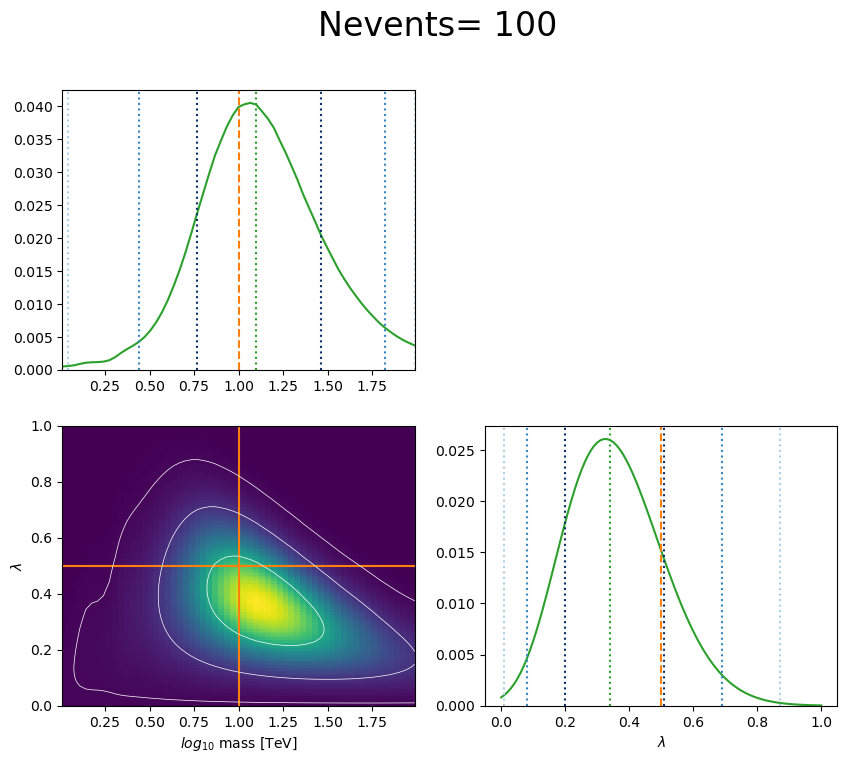

In [57]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmassval, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmassval, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\lambda$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\lambda$')
ax[1,1].set_ylim([0, None])


plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmassval}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

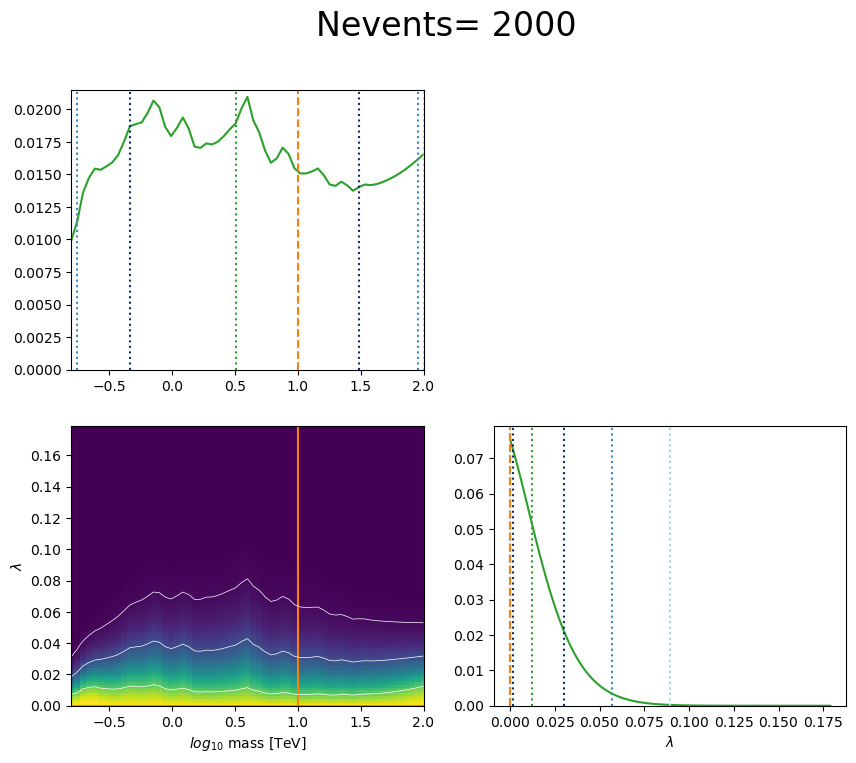

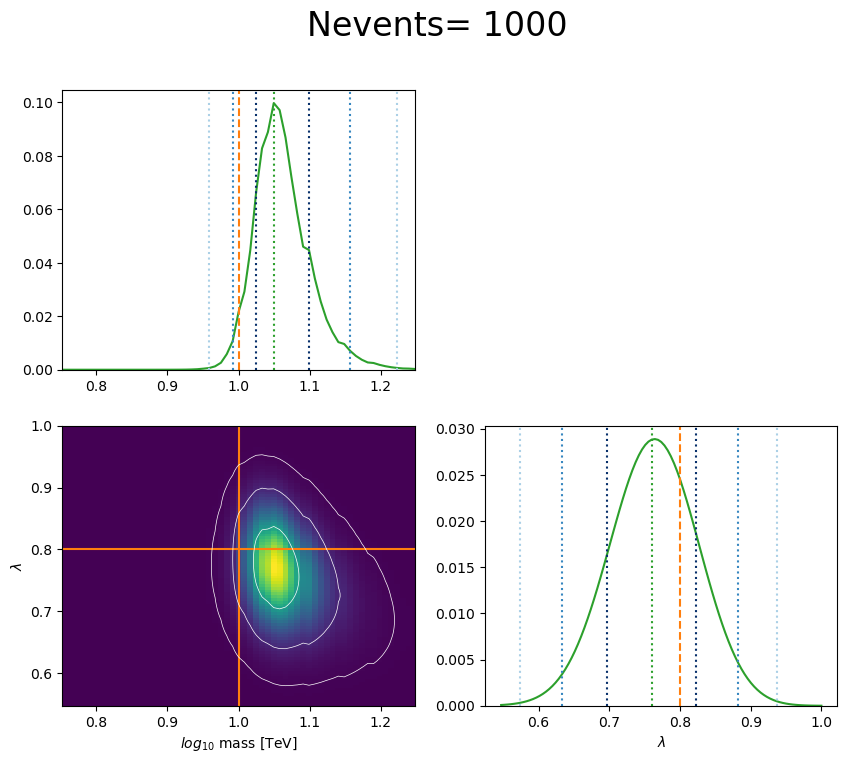

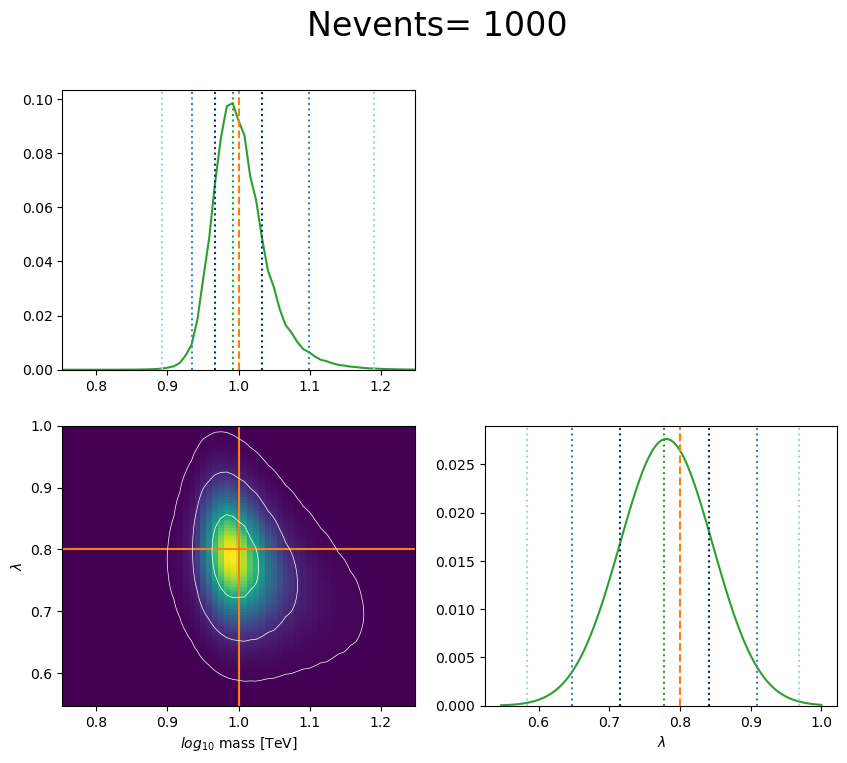

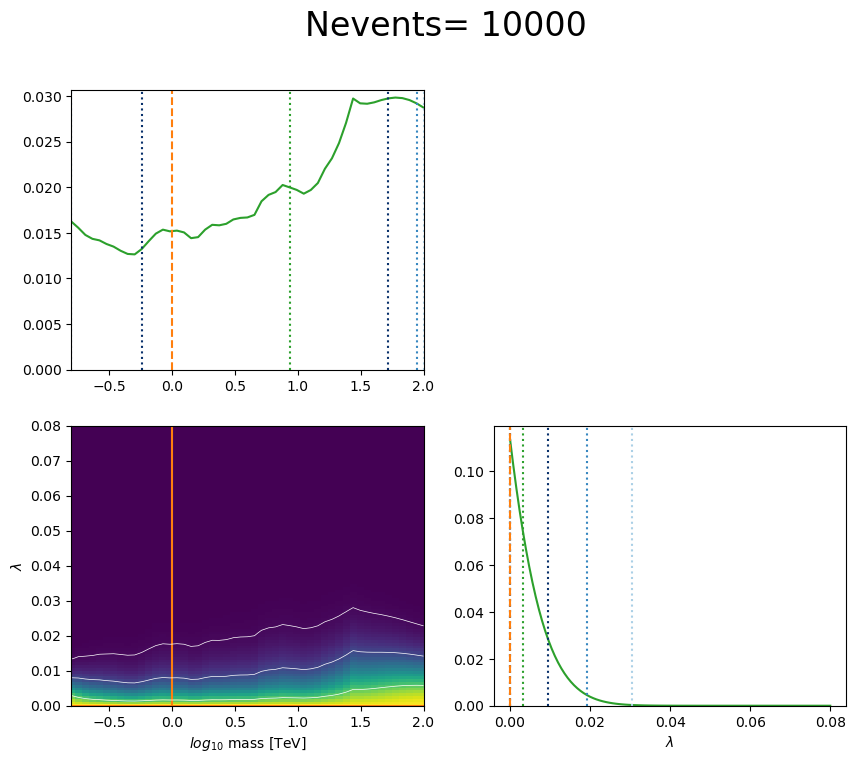

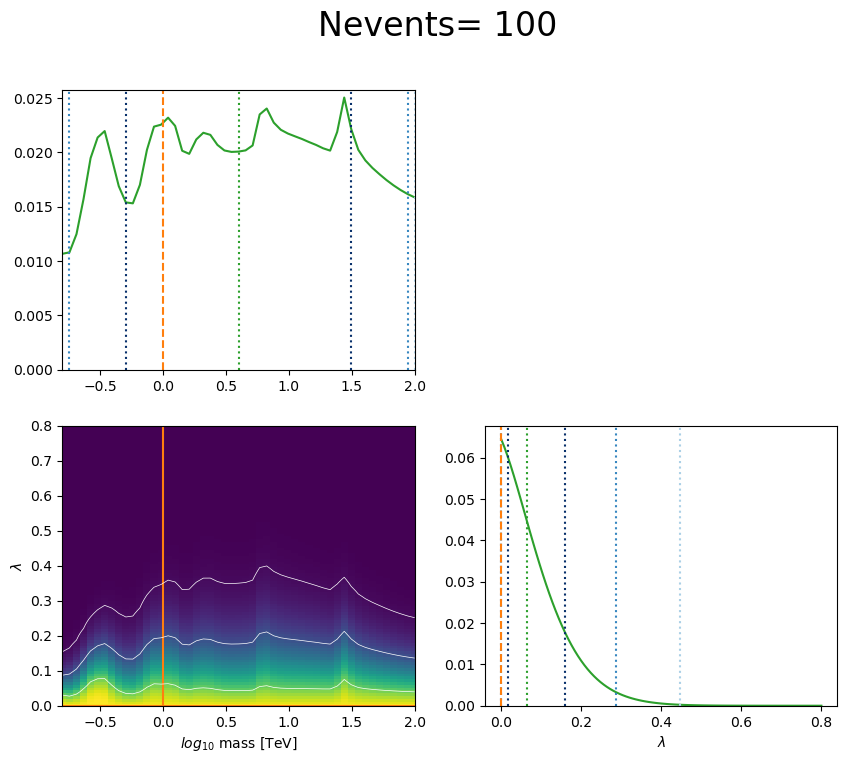

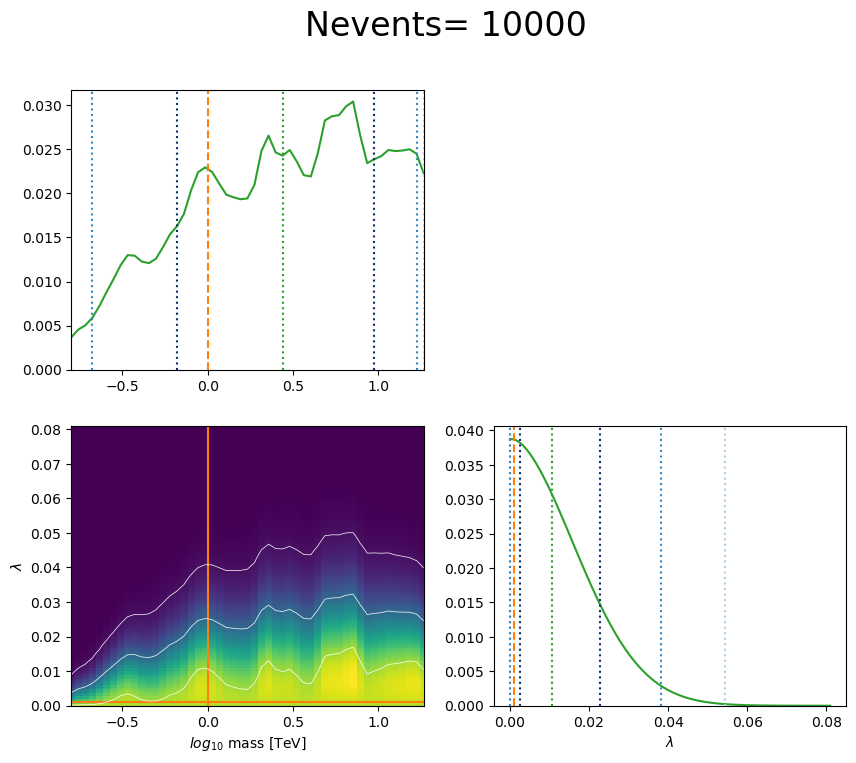

In [58]:
import os
os.system('say Your code is finished.')

0